In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost                       #For training an extreme gradient boosting model on data
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures  #For standardizing/tranforming numeric variables
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV  #For performing model cross-validation
from sklearn.metrics import log_loss, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score,\
    recall_score, f1_score, fbeta_score, precision_recall_curve, roc_curve, roc_auc_score, auc, make_scorer  #For evaluating classifier model


pd.set_option('display.max_columns', None)

In [2]:
# loading csv, choosing variables, checking for null values
# we are including pop_density for now, but will drop it after we make the urban cutoff

df = pd.read_csv('../../data/census_epa_theil_cleaned.csv')
df = df[[
    'pop_density',
    'PM25',
    'PTRAF',
    'PRE1960PCT',
    'PNPL',
    'PRMP',
    'PTSDF',
    'UST',
    'PWDIS'
]]

print(df.isnull().sum())

pop_density    0
PM25           0
PTRAF          0
PRE1960PCT     0
PNPL           0
PRMP           0
PTSDF          0
UST            0
PWDIS          0
dtype: int64


In [3]:
# setting PM25_high as target binary variable, making urban cutoff, and checking for class balance

df['PM25_high'] = np.where(df['PM25'] > 9, 1 ,0)
df = df[df['pop_density'] > 500]

print(len(df[df['PM25_high']==1])/len(df))

0.3383888203863543


In [4]:
# separating independent and dependent variables, dropping pop_density from X

y = df['PM25_high']
X = df.drop(['pop_density', 'PM25', 'PM25_high'], axis=1)

In [5]:
# 68/12/20 train-val-test split with stratification and seed=201

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=201, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=201, stratify=y_train_val)

print("Original high percent: " + str(y.sum()/len(y)))
print("Train high percent: " + str(y_train.sum()/len(y_train)))
print("Val high percent: " + str(y_val.sum()/len(y_val)))
print("Test high percent: " + str(y_test.sum()/len(y_test)))
print("The train/val/test split percent is: " + str(len(y_train)/len(y)*100) + " / " + str(len(y_val)/len(y)*100) + " / " + str(len(y_test)/len(y)*100))

Original high percent: 0.3383888203863543
Train high percent: 0.33840062862669246
Val high percent: 0.33835616438356164
Test high percent: 0.33836826962597616
The train/val/test split percent is: 67.99835593916976 / 12.00164406083025 / 20.0


In [6]:
# scaling our data-- minmax scaler for everything
# fit on just the training set to minimize leakage

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [7]:
# defining the f2 metric (since there isn't one built-in, it's a common special case of fbeta metric)
# Note: this is the negative since xgboost minimizes its objective function

def f2_eval(y_pred, dmatrix):
    y_true = dmatrix.get_label()
    y_pred_binary = (y_pred > 0.5).astype(int)

    f2 = fbeta_score(y_true, y_pred_binary, beta=2)
    
    return 'f2_score', -f2


In [8]:
# making the xgboost model and training it to make sure everything's set up properly
# objective = binary:logistic is standard
# missing = -999 because we don't have any missing data
# seed = 201 is random, just using 201 for all random seeds
# scale_pos_weight is the standard recommendation: scale_pos_weight = low-risk/high-risk = 0.73/0.27 = 2.7
# learning_rate=0.3 to start out high and make hyperparameter tuning faster
# we'll tune the other hyperparameters below

xgb_clf = xgboost.XGBClassifier(objective='binary:logistic', missing=-999, seed=201, scale_pos_weight=2, learning_rate=0.3)
xgb_clf = xgb_clf.fit(
    X_train,
    y_train,
    verbose=True,
    eval_metric = f2_eval,
    eval_set = [(X_val, y_val)],
    early_stopping_rounds = 20
)


[0]	validation_0-logloss:0.64648	validation_0-f2_score:-0.65785
[1]	validation_0-logloss:0.61119	validation_0-f2_score:-0.70286
[2]	validation_0-logloss:0.59145	validation_0-f2_score:-0.70985
[3]	validation_0-logloss:0.57716	validation_0-f2_score:-0.72707
[4]	validation_0-logloss:0.56625	validation_0-f2_score:-0.72820
[5]	validation_0-logloss:0.55842	validation_0-f2_score:-0.72454
[6]	validation_0-logloss:0.55206	validation_0-f2_score:-0.72292
[7]	validation_0-logloss:0.54793	validation_0-f2_score:-0.72326
[8]	validation_0-logloss:0.54366	validation_0-f2_score:-0.72354
[9]	validation_0-logloss:0.54023	validation_0-f2_score:-0.72434
[10]	validation_0-logloss:0.53891	validation_0-f2_score:-0.72527
[11]	validation_0-logloss:0.53774	validation_0-f2_score:-0.72743
[12]	validation_0-logloss:0.53595	validation_0-f2_score:-0.72560
[13]	validation_0-logloss:0.53381	validation_0-f2_score:-0.72403
[14]	validation_0-logloss:0.53233	validation_0-f2_score:-0.72476
[15]	validation_0-logloss:0.52586	v

c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is dep

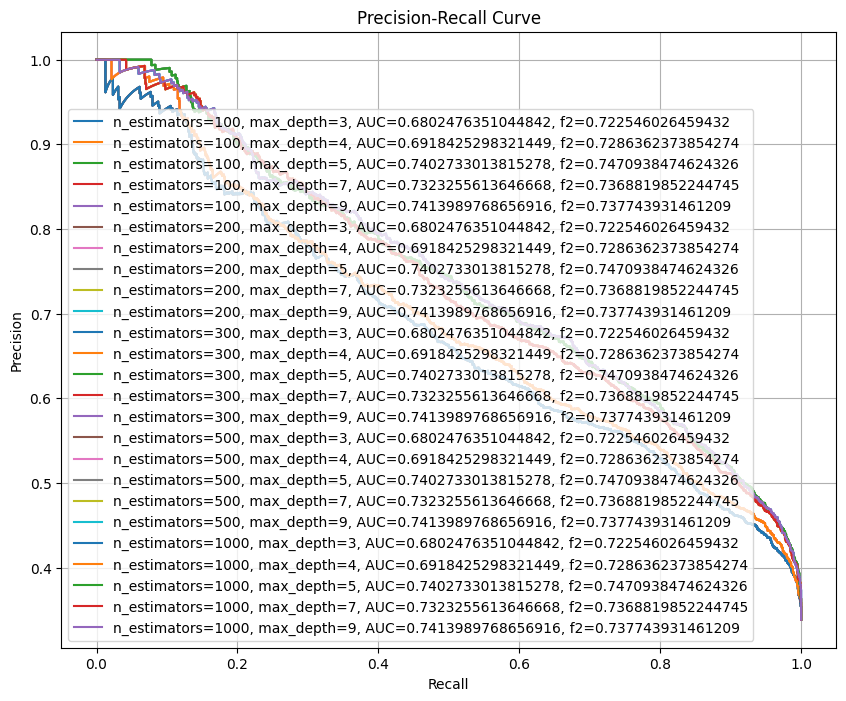

In [9]:
# we'll use this for loop before gridsearchCV to find best values of n_estimators and max_depth while minimizing overfitting risk
# this code plots the PR curves for all the values of n_estimators and max_depth below
# then, we'll take the lowest values that give the best AUC-PR
# looks like the best one is (100,9), but we'll do another for loop to see if going past 9 is even better

n_estimators_values = [100,200,300,500,1000]
max_depth_values = [3,4,5,7,9]

plt.figure(figsize=(10,8))

for n in n_estimators_values:
    for m in max_depth_values:
        xgb_clf_nm = xgboost.XGBClassifier(objective='binary:logistic', missing=-999, seed=201, scale_pos_weight=2, learning_rate=0.3, n_estimators=n, max_depth=m)
        xgb_clf_nm = xgb_clf_nm.fit(
            X_train,
            y_train,
            verbose=False,
            eval_metric = f2_eval,
            eval_set = [(X_val, y_val)],
            early_stopping_rounds = 20,
        )
        y_prob = xgb_clf_nm.predict_proba(X_val)[:,1]
        precision, recall, _ = precision_recall_curve(y_val, y_prob)
        auc_score = auc(recall, precision)
        
        y_pred = xgb_clf_nm.predict(X_val)
        f2 = fbeta_score(y_val, y_pred, beta=2)

        plt.plot(recall, precision, label = f'n_estimators={n}, max_depth={m}, AUC={auc_score}, f2={f2}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is dep

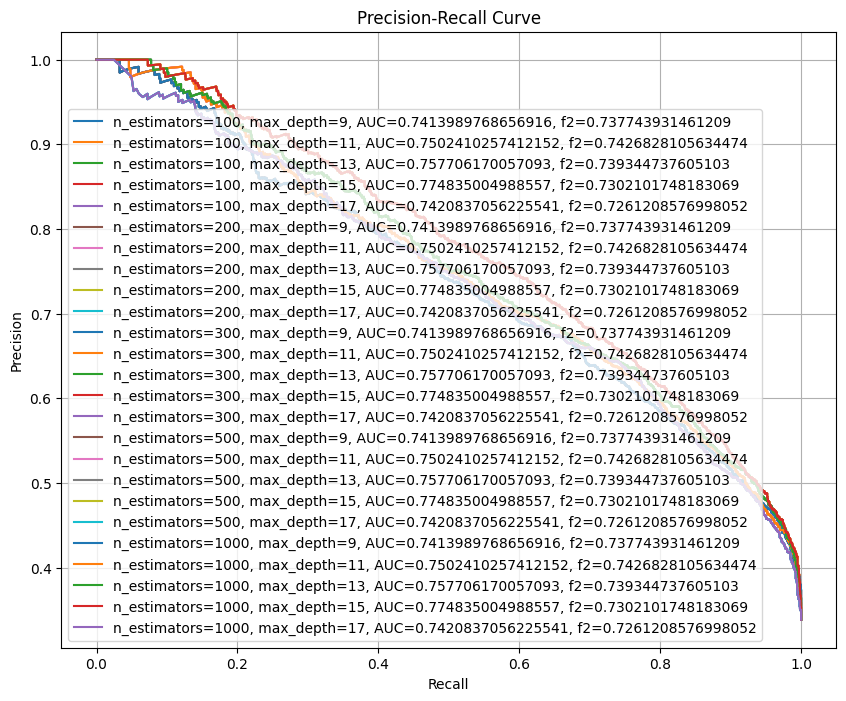

In [10]:
# continuing the for loop from the last panel with higher depth
# looks like (100,11) or (100,15) is best

n_estimators_values = [100,200,300,500,1000]
max_depth_values = [9,11,13,15,17]

plt.figure(figsize=(10,8))

for n in n_estimators_values:
    for m in max_depth_values:
        xgb_clf_nm = xgboost.XGBClassifier(objective='binary:logistic', missing=-999, seed=201, scale_pos_weight=2, learning_rate=0.3, n_estimators=n, max_depth=m)
        xgb_clf_nm = xgb_clf_nm.fit(
            X_train,
            y_train,
            verbose=False,
            eval_metric = f2_eval,
            eval_set = [(X_val, y_val)],
            early_stopping_rounds = 20,
        )
        y_prob = xgb_clf_nm.predict_proba(X_val)[:,1]
        precision, recall, _ = precision_recall_curve(y_val, y_prob)
        auc_score = auc(recall, precision)
        
        y_pred = xgb_clf_nm.predict(X_val)
        f2 = fbeta_score(y_val, y_pred, beta=2)

        plt.plot(recall, precision, label = f'n_estimators={n}, max_depth={m}, AUC={auc_score}, f2={f2}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# gridsearchCV to help tune hyperparameters
# for our first grid search, we'll try some regularization
# looks like max_depth=11 is doing the best, with min_child_weight=3 and reg_lambda=10

xgb_clf = xgboost.XGBClassifier(objective='binary:logistic', missing=-999, seed=201, scale_pos_weight=2, learning_rate=0.3, n_estimators=100, max_depth=15)

f2_scorer = make_scorer(fbeta_score, beta=2)
param_grid = {
    'max_depth' : [11,15],
    'min_child_weight' : [1,2,3],
    'colsample_bytree' : [0.8,0.9,1],
    'reg_lambda' : [0,1,10]
}

grid_search = GridSearchCV(xgb_clf, param_grid, scoring=f2_scorer, cv=5, verbose=1, n_jobs=1)

grid_search.fit(X_train,y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best f2: ", grid_search.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Hyperparameters: {'colsample_bytree': 1, 'max_depth': 11, 'min_child_weight': 3, 'reg_lambda': 10}
Best f2:  0.6860904996088589


c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is dep

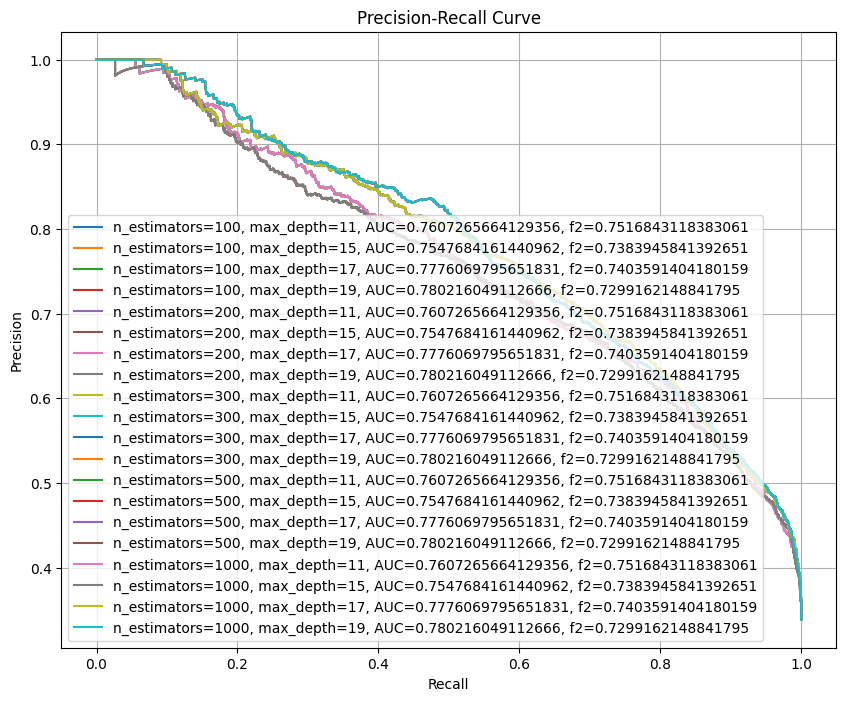

In [13]:
# now that we have some regularization, let's see how far we can increase max_depth and n_estimators
# looks like (100,11) has the best f2 and (100,19) has the best AUC-PR

n_estimators_values = [100,200,300,500,1000]
max_depth_values = [11,15,17,19]

plt.figure(figsize=(10,8))

for n in n_estimators_values:
    for m in max_depth_values:
        xgb_clf_nm = xgboost.XGBClassifier(objective='binary:logistic', missing=-999, seed=201, scale_pos_weight=2, learning_rate=0.3, reg_lambda=10, min_child_weight=3, n_estimators=n, max_depth=m)
        xgb_clf_nm = xgb_clf_nm.fit(
            X_train,
            y_train,
            verbose=False,
            eval_metric = f2_eval,
            eval_set = [(X_val, y_val)],
            early_stopping_rounds = 20,
        )
        y_prob = xgb_clf_nm.predict_proba(X_val)[:,1]
        precision, recall, _ = precision_recall_curve(y_val, y_prob)
        auc_score = auc(recall, precision)
        
        y_pred = xgb_clf_nm.predict(X_val)
        f2 = fbeta_score(y_val, y_pred, beta=2)

        plt.plot(recall, precision, label = f'n_estimators={n}, max_depth={m}, AUC={auc_score}, f2={f2}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# maybe more aggressive regularization helps increase max_depth
# looks like (100,11) is working well, and we'll add in reg_alpha=0.01

xgb_clf = xgboost.XGBClassifier(objective='binary:logistic', missing=-999, seed=201, scale_pos_weight=2, learning_rate=0.3, n_estimators=100, min_child_weight=3, reg_lambda=10)

f2_scorer = make_scorer(fbeta_score, beta=2)
param_grid = {
    'max_depth' : [11,19],
    'subsample' : [0.8,0.9,1],
    'colsample_bytree' : [0.8,0.9,1],
    'reg_alpha' : [0,0.01,0.1]
}

grid_search = GridSearchCV(xgb_clf, param_grid, scoring=f2_scorer, cv=5, verbose=1, n_jobs=1)

grid_search.fit(X_train,y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best f2: ", grid_search.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Hyperparameters: {'colsample_bytree': 1, 'max_depth': 11, 'reg_alpha': 0.01, 'subsample': 1}
Best f2:  0.7070494071682478


c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:22:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_child_weigh" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\

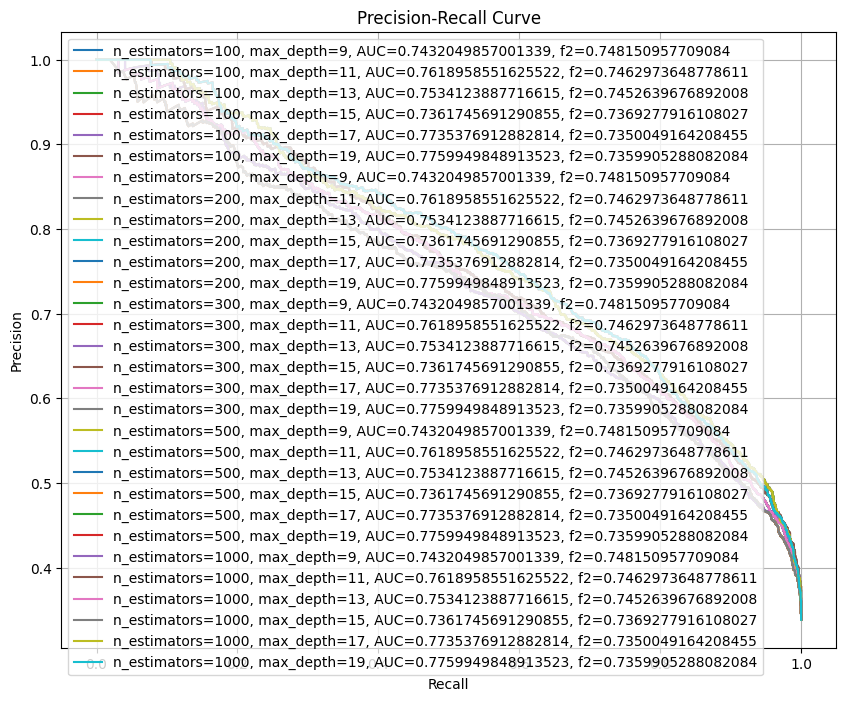

In [21]:
# one more loop to try different max_depth and n_estimators
# max_depth=9 is giving the best f2, and 19 is giving the best AUC-PR

n_estimators_values = [100,200,300,500,1000]
max_depth_values = [9,11,13,15,17,19]

plt.figure(figsize=(10,8))

for n in n_estimators_values:
    for m in max_depth_values:
        xgb_clf_nm = xgboost.XGBClassifier(objective='binary:logistic', missing=-999, seed=201, scale_pos_weight=2, learning_rate=0.3, reg_lambda=10, reg_alpha=0.01, min_child_weigh=3, n_estimators=n, max_depth=m)
        xgb_clf_nm = xgb_clf_nm.fit(
            X_train,
            y_train,
            verbose=False,
            eval_metric = f2_eval,
            eval_set = [(X_val, y_val)],
            early_stopping_rounds = 20,
        )
        y_prob = xgb_clf_nm.predict_proba(X_val)[:,1]
        precision, recall, _ = precision_recall_curve(y_val, y_prob)
        auc_score = auc(recall, precision)
        
        y_pred = xgb_clf_nm.predict(X_val)
        f2 = fbeta_score(y_val, y_pred, beta=2)

        plt.plot(recall, precision, label = f'n_estimators={n}, max_depth={m}, AUC={auc_score}, f2={f2}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# finally, let's tune the learning rate
# we'll also include some different max_depths in here since it's fast and could change our best depth
# looks like learning_rate=0.1 is best

xgb_clf = xgboost.XGBClassifier(objective='binary:logistic', missing=-999, seed=201, scale_pos_weight=2, n_estimators=100, reg_alpha=0.01, min_child_weight=3)

f2_scorer = make_scorer(fbeta_score, beta=2)
param_grid = {
    'max_depth' : [5,7,9,19],
    'reg_lambda' : [1,10,50,100]
}

grid_search = GridSearchCV(xgb_clf, param_grid, scoring=f2_scorer, cv=5, verbose=1, n_jobs=1)

grid_search.fit(X_train,y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best f2: ", grid_search.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparameters: {'max_depth': 7, 'reg_lambda': 100}
Best f2:  0.7258428318093684


In [25]:
# finally, let's tune the learning rate
# looks like learning_rate=0.1 is best

xgb_clf = xgboost.XGBClassifier(objective='binary:logistic', missing=-999, seed=201, scale_pos_weight=2, n_estimators=200, max_depth=7, min_child_weight=3, reg_alpha=0.01, reg_lambda=100)

f2_scorer = make_scorer(fbeta_score, beta=2)
param_grid = {
    'learning_rate' : [0.01, 0.05, 0.1, 0.2, 0.3]
}

grid_search = GridSearchCV(xgb_clf, param_grid, scoring=f2_scorer, cv=5, verbose=1, n_jobs=1)

grid_search.fit(X_train,y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best f2: ", grid_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Hyperparameters: {'learning_rate': 0.2}
Best f2:  0.7247660935915075


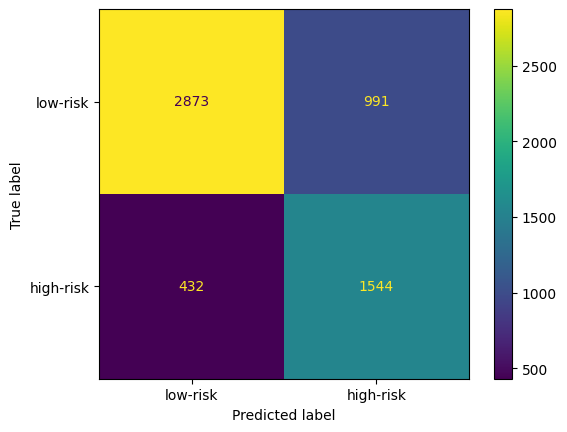

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


accuracy: 0.7563356164383561 | baseline: 0.6616438356164384
precision: 0.6090729783037475 | baseline: 0.33835616438356164
recall: 0.7813765182186235 | baseline: 1
f1 score: 0.6845488805142984 | baseline: 0.5056294779938588
f2 score: 0.7395344381645752 | baseline: 0.7188591385331781
AUC-PR: 0.7537344854963713 | baseline: 0.33835616438356164


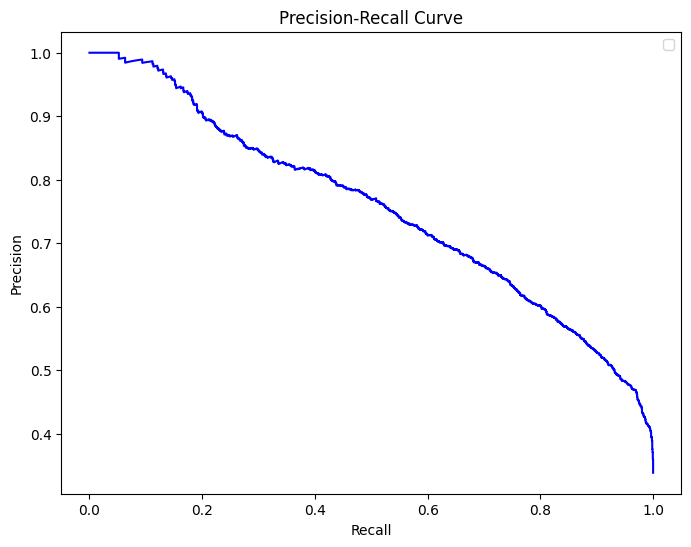

In [26]:
# evaluating all the metrics we want on the val data

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
y_prob = best_model.predict_proba(X_val)[:,1]

high_pct = y_val.sum()/len(y_val)
cm = confusion_matrix(y_val, y_pred)
precision, recall, _ = precision_recall_curve(y_val, y_prob)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["low-risk", "high-risk"])
disp.plot()
plt.show()

print("accuracy: " + str(accuracy_score(y_val, y_pred)) + " | baseline: " + str(1-high_pct))
print("precision: " + str(precision_score(y_val, y_pred)) + " | baseline: " + str(high_pct))
print("recall: " + str(recall_score(y_val, y_pred)) + " | baseline: " + str(1))
print("f1 score: " + str(fbeta_score(y_val, y_pred, beta=1)) + " | baseline: " + str(2*high_pct/(high_pct+1)))
print("f2 score: " + str(fbeta_score(y_val, y_pred, beta=2)) + " | baseline: " + str(5*high_pct/(4*high_pct+1)))
print("AUC-PR: " + str(auc(recall, precision)) + " | baseline: " + str(high_pct))

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

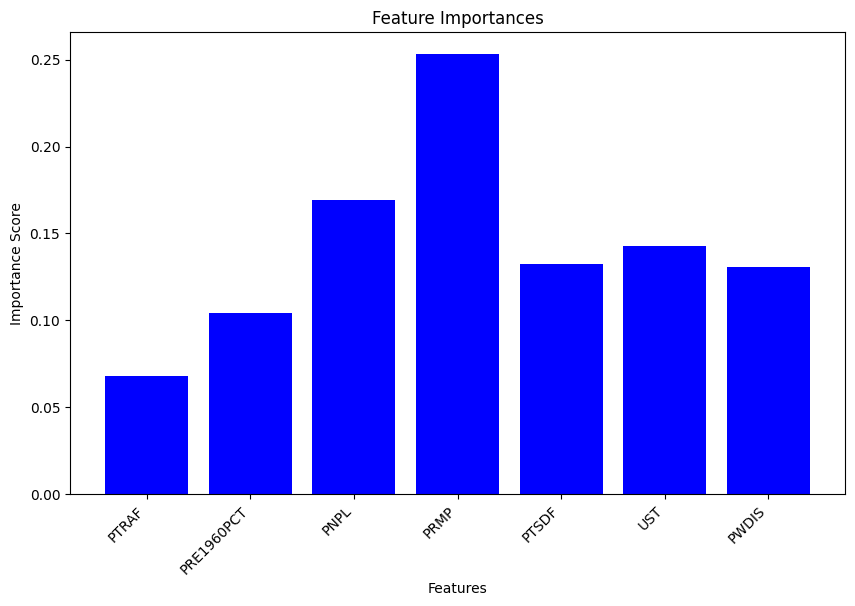

In [27]:
# computing feature importance

df_features = df.drop(['PM25', 'PM25_high', 'pop_density'], axis=1)

df_columns = df_features.columns.tolist()
feature_importance = best_model.feature_importances_

plt.figure(figsize=(10, 6))
plt.bar(df_columns, feature_importance, color='blue')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importances')
plt.xticks(rotation=45, ha='right')
plt.show()

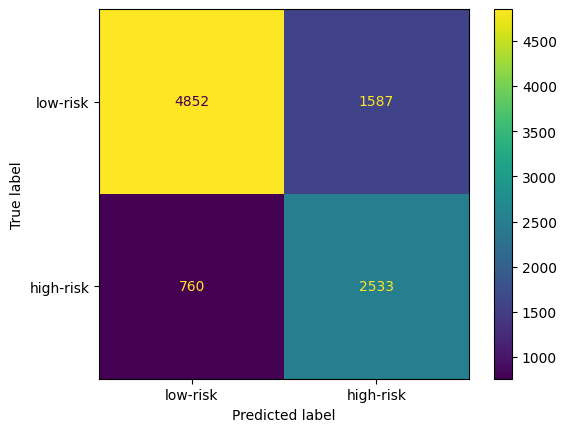

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


accuracy: 0.7588368269625976 | baseline: 0.33836826962597616
precision: 0.6148058252427184 | baseline: 0.33836826962597616
recall: 0.7692074096568479 | baseline: 1
f1 score: 0.6833940375016861 | baseline: 0.5056429942418426
f2 score: 0.7324196160074022 | baseline: 0.7188700663639539
AUC-PR: 0.7536029962823558 | baseline: 0.33836826962597616


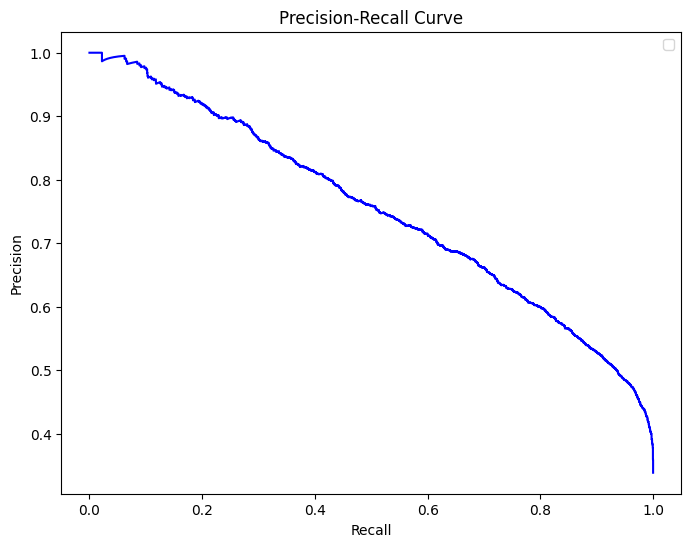

In [28]:
# evaluating all the metrics we want on the val data
# baseline = label everything high-risk

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:,1]

high_pct = y_test.sum()/len(y_test)
cm = confusion_matrix(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_prob)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["low-risk", "high-risk"])
disp.plot()
plt.show()

print("accuracy: " + str(accuracy_score(y_test, y_pred)) + " | baseline: " + str(high_pct))
print("precision: " + str(precision_score(y_test, y_pred)) + " | baseline: " + str(high_pct))
print("recall: " + str(recall_score(y_test, y_pred)) + " | baseline: " + str(1))
print("f1 score: " + str(fbeta_score(y_test, y_pred, beta=1)) + " | baseline: " + str(2*high_pct/(high_pct+1)))
print("f2 score: " + str(fbeta_score(y_test, y_pred, beta=2)) + " | baseline: " + str(5*high_pct/(4*high_pct+1)))
print("AUC-PR: " + str(auc(recall, precision)) + " | baseline: " + str(high_pct))

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()